# Dibuat Oleh  Muhammad Afiq & Niken Ayu

# Membuat Prediksi Ras Anjing menggunakan Convolutional Neural Network (CNN)

CNN (Convolutional Neural Network) adalah jenis arsitektur neural network yang dirancang khusus untuk pengolahan data grid, seperti gambar dan video. CNN sangat efektif dalam tugas pengenalan pola visual, membuatnya sangat cocok untuk aplikasi pengenalan gambar, klasifikasi, deteksi objek, dan segmentasi.
komponen utama dari arsitektur CNN:
Layer Konvolusi untuk mengekstrak fitur-fitur dari gambar
Layer ReLU untuk mengubah nilai-nilai negatif menjadi nol dan membiarkan nilai-nilai positif tetap tidak berubah
Layer pooling untuk mengurangi dimensi spasial dari representasi fitur serta mengurangi beban komputasi dalam jaringan
Layer Flattern untuk mengonversi data hasil pooling menjadi bentuk vektor satu dimensi
Layer Dense untuk  menggabungkan fitur-fitur yang telah diekstrak untuk pengambilan keputusan akhir.



# Download data from Kaggle

https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp


# Importing libraries

menginstal library yang dibutuhkan seperti numpy,pandas,keras,tenserflow,scikit-learn dan matplotlib
numpy digunakan untuk operasi numerik, pandas untuk manipulasi data tabular, dan matplotlib untuk visualisasi.
Tensorflow menyediakan konstruksi graf komputasi yang dapat dihitung secara efisien
Keras menyediakan lapisan-lapisan yang dapat digunakan untuk membangun arsitektur model, dukungan untuk berbagai jenis lapisan konvolusional, rekurent, dll.
Scikit-learn menyediakan antarmuka yang konsisten dan mudah digunakan untuk berbagai algoritma pembelajaran mesin, serta fungsi untuk evaluasi model dan pemrosesan data.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow

import tqdm as tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

# memanggil dataset

Panggilan pd.read_csv("labels.csv") dalam konteks pandas digunakan untuk membaca data dari file CSV ke dalam bentuk DataFrame di Python.


In [5]:
df = pd.read_csv("dataset/labels.csv")

# membaca dataset

kode bertujuan untuk membaca data dari file "labels.csv", menampilkan informasi tentang bentuk DataFrame, dan menampilkan beberapa baris pertama dari DataFrame tersebut.

In [6]:
# view labels
labels_all = pd.read_csv('dataset/labels.csv')

print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever




kode bertujuan untuk menampilkan jumlah jenis breed yang unik yang terdapat dalam kolom 'breed' dari DataFrame labels_all

In [7]:
# Getting the number of unique breeds present
breeds_all = labels_all['breed']
print('Total number of unique breeds:')
print(len(breeds_all.unique()))

Total number of unique breeds:
120


 menampilkan baris teratas (nilai yang paling umum) dalam variabel breeds_all, yang berisi data kategori yang mewakili berbagai ras anjing.

In [8]:
print(breeds_all.value_counts().head())

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: count, dtype: int64


menampilkan baris terakhir (nilai yang paling jarang) dalam variabel breeds_all, yang  berisi data kategori yang mewakili berbagai ras anjing. 

In [9]:
print(breeds_all.value_counts().tail())

breed
golden_retriever     67
brabancon_griffon    67
komondor             67
eskimo_dog           66
briard               66
Name: count, dtype: int64


membuat daftar (class_names) yang berisi nama-nama ras anjing yang paling umum, dengan memanfaatkan hasil dari value_counts() dan mengambil tiga nilai teratas.

In [10]:
class_names = []
for i in breeds_all.value_counts().head(3).index:
  class_names.append(i)
print(class_names)

['scottish_deerhound', 'maltese_dog', 'afghan_hound']


 membuat subset baru dari DataFrame labels_all, hanya menyertakan baris yang memiliki nilai pada kolom 'breed' yang termasuk dalam daftar class_names

In [32]:
labels = labels_all[labels_all['breed'].isin(class_names)]

menampilkan beberapa baris pertama dari DataFrame labels yang telah difilter. 

In [12]:
labels.head()

,id,breed
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
12,00693b8bc2470375cc744a6391d397ec,maltese_dog
79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
146,0379145880ad3978f9b80f0dc2c03fba,afghan_hound


menghasilkan DataFrame labels yang memiliki indeks yang baru dan berurutan, dan kolom indeks lama akan dihapus.

In [13]:
labels.reset_index(inplace=True, drop=True)

menampilkan beberapa baris pertama dari DataFrame labels yang telah diurutkan

In [14]:
labels.head()

,id,breed
0,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,0379145880ad3978f9b80f0dc2c03fba,afghan_hound


mencetak jumlah baris (jumlah sampel) dalam DataFrame labels setelah proses diurutkan

In [15]:
print('Training data after screening: {}'.format(labels.shape[0]))

Training data after screening: 359


# Image preprocessing

Membuat matriks nol dengan dimensi (jumlah sampel, 224, 224, 3). Ini akan digunakan untuk menyimpan data gambar setelah diubah ukurannya dan dinormalisasi. Setiap sampel data adalah gambar dengan ukuran 224x224 piksel dan memiliki tiga saluran warna.
Menyimpan hasilnya ke dalam matriks X_data setelah dinormalisasi dengan membaginya dengan 255.0
Hasil akhirnya adalah matriks X_data yang berisi data gambar yang telah diubah ukurannya dan dinormalisasi, serta matriks Y_data yang berisi label dalam bentuk one-hot encoding. Kode ini bersiap untuk digunakan sebagai input dan output dalam pelatihan model neural network.

In [16]:
# Creating a zero matrix first for initialization
X_data = np.zeros((labels.shape[0], 224, 224, 3), dtype='float32')

# One hot encoding
Y_data = label_binarize(labels['breed'], classes = class_names)

# Reading and converting image into numpy format and then normalizing it

for i in tqdm.tqdm(range(len(labels))):
  img = image.load_img('dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
  img = image.img_to_array(img)
  x = np.expand_dims(img.copy(), axis=0)
  X_data[i] = x/255.0


  9%|▉         | 32/359 [00:00<00:02, 153.18it/s]

100%|██████████| 359/359 [00:01<00:00, 191.17it/s]


membuat bentuk (shape) dari matriks X_data.

In [17]:
print(X_data.shape)

(359, 224, 224, 3)


membuat bentuk (shape) dari matriks Y_data.

In [18]:
print(Y_data.shape)

(359, 3)


# Model building

Model ini terdiri dari beberapa lapisan konvolusional, lapisan pooling untuk mereduksi dimensi, dan lapisan fully connected untuk klasifikasi. Regularisasi L2 diterapkan untuk mencegah overfitting. Fungsi aktivasi yang umum digunakan adalah ReLU pada lapisan-lapisan konvolusional dan fully connected, sedangkan lapisan output menggunakan softmax untuk tugas klasifikasi multikelas.

In [19]:
# Building the Model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(3, activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 16)       

membagi dataset menjadi tiga subset: training set, validation set, dan testing set.
i subset training yang lebih kecil untuk melatih model, subset validation untuk mengevaluasi performa model selama pelatihan, dan subset testing yang terpisah sepenuhnya untuk mengevaluasi performa model setelah pelatihan.

In [20]:
# Splitting the data set into training and testing data sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size = 0.2)

melatih model menggunakan data training (Xtrain dan Ytrain) dan memonitor performa model pada data validation (Xval dan Yval).

In [21]:
# Training the model
epochs = 30
batch_size = 36
history = model.fit(Xtrain, Ytrain, batch_size = batch_size, epochs = epochs, validation_data = (Xval, Yval))

Epoch 1/30


8/8 [==============================] - 29s 3s/step - loss: 4.8633 - accuracy: 0.3333 - val_loss: 4.8067 - val_accuracy: 0.3692
Epoch 2/30
8/8 [==============================] - 21s 3s/step - loss: 4.7680 - accuracy: 0.3372 - val_loss: 4.7157 - val_accuracy: 0.3385
Epoch 3/30
8/8 [==============================] - 25s 3s/step - loss: 4.6768 - accuracy: 0.3450 - val_loss: 4.6288 - val_accuracy: 0.3538
Epoch 4/30
8/8 [==============================] - 19s 2s/step - loss: 4.5846 - accuracy: 0.3760 - val_loss: 4.5527 - val_accuracy: 0.4154
Epoch 5/30
8/8 [==============================] - 21s 3s/step - loss: 4.5007 - accuracy: 0.4457 - val_loss: 4.4709 - val_accuracy: 0.4308
Epoch 6/30
8/8 [==============================] - 23s 3s/step - loss: 4.4108 - accuracy: 0.4961 - val_loss: 4.3795 - val_accuracy: 0.4769
Epoch 7/30
8/8 [==============================] - 22s 3s/step - loss: 4.3216 - accuracy: 0.4961 - val_loss: 4.3148 - val_accuracy: 0.4923
Epoch 8/30
8/8 [================

 membuat plot dari histori akurasi pelatihan dan validasi.

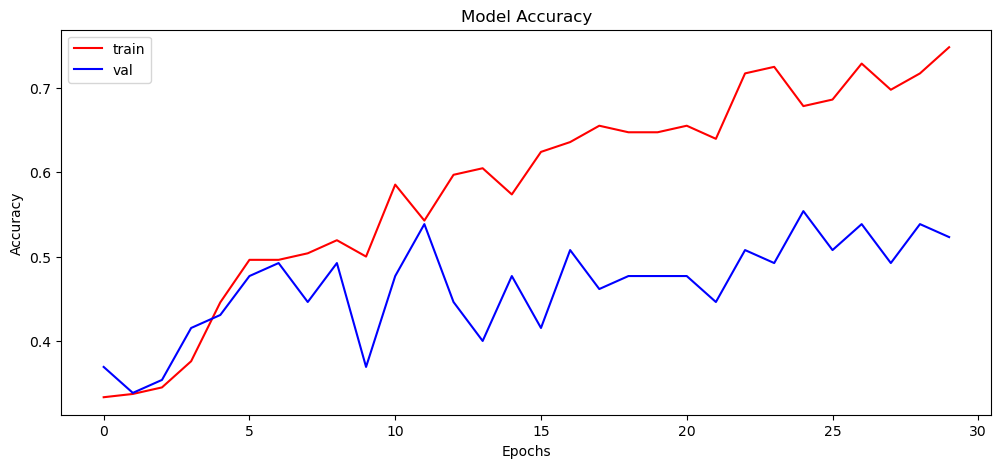

In [26]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

membuat prediksi menggunakan model pada data testing (Xtest) dan  mencetak akurasi model pada data testing dalam format persentase

In [29]:
Y_pred = model.predict(Xtest)
score = model.evaluate(Xtest, Ytest)
print('Accuracy over the test set: \n ', round((score[1]*120), 2), '%')

2/2 [==============================] - 5s 54ms/step - loss: 2.8876 - accuracy: 0.6944
Accuracy over the test set: 
  83.33 %


memplot gambar dari data testing dan membandingkan nilai prediksi model dengan nilai asli
Jika prediksi model sesuai dengan nilai asli, ini menunjukkan bahwa model berhasil memprediksi

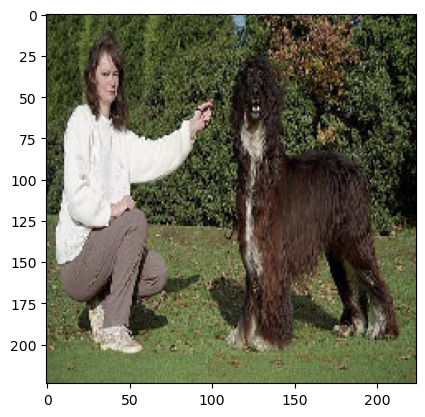

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [30]:
# Plotting image to compare
plt.imshow(Xtest[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Ytest[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])

menyimpan model ke dalam file dengan format Hierarchical Data Format (HDF5).

In [31]:
model.save('dog_breed.h5')